## Project Description

This project classify the phone user behavior based on the usage scaling from 1 to 5. The bigger the number, the more user use the phone. The features inside this dataset is:
- User ID
- Device Model
- Operating System
- App Usage Time (min/day)
- Screen On Time (hours/day)
- Battery Drain (mAh/day)
- Number of Apps Installed
- Data Usage (MB/ day)
- Age
- Gender
- User Behavior Class

The dataset used is from kaggle, link: https://www.kaggle.com/datasets/valakhorasani/mobile-device-usage-and-user-behavior-dataset 

## Import the relevant libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mutual_info_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
import pickle

## Load the dataset

In [61]:
df = pd.read_csv('data/user_behavior_dataset.csv')
df.head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User ID                     700 non-null    int64  
 1   Device Model                700 non-null    object 
 2   Operating System            700 non-null    object 
 3   App Usage Time (min/day)    700 non-null    int64  
 4   Screen On Time (hours/day)  700 non-null    float64
 5   Battery Drain (mAh/day)     700 non-null    int64  
 6   Number of Apps Installed    700 non-null    int64  
 7   Data Usage (MB/day)         700 non-null    int64  
 8   Age                         700 non-null    int64  
 9   Gender                      700 non-null    object 
 10  User Behavior Class         700 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 60.3+ KB


In [8]:
df.isnull().sum()

User ID                       0
Device Model                  0
Operating System              0
App Usage Time (min/day)      0
Screen On Time (hours/day)    0
Battery Drain (mAh/day)       0
Number of Apps Installed      0
Data Usage (MB/day)           0
Age                           0
Gender                        0
User Behavior Class           0
dtype: int64

There's no null value inside the dataset

In [10]:
# Turn the column names into lowercase
df.columns = df.columns.str.lower().str.replace(' ', '_')

We should mapping the target (`user_behavior_class`) from 0 to 4, instead from 1 to 5. (Multiclass need arrange from 0 for xgboost, and not doing this will cause an error)

In [12]:
# mapping the user_behavior_class from 0 to 4
df.user_behavior_class = df.user_behavior_class.map({1:0, 2:1, 3:2, 4:3, 5:4})

In [13]:
# Mapping the gender into number 
df.gender = df.gender.map({'Female': 0, 'Male': 1})

In [14]:
df.user_behavior_class.value_counts()

user_behavior_class
1    146
2    143
3    139
4    136
0    136
Name: count, dtype: int64

In [15]:
# drop the user_id
del df['user_id']

## EDA

In [17]:
df.describe()

,app_usage_time_(min/day),screen_on_time_(hours/day),battery_drain_(mah/day),number_of_apps_installed,data_usage_(mb/day),age,gender,user_behavior_class
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,271.128571,5.272714,1525.158571,50.681429,929.742857,38.482857,0.520000,1.990000
std,177.199484,3.068584,819.136414,26.943324,640.451729,12.012916,0.499957,1.401476
min,30.000000,1.000000,302.000000,10.000000,102.000000,18.000000,0.000000,0.000000
25%,113.250000,2.500000,722.250000,26.000000,373.000000,28.000000,0.000000,1.000000
50%,227.500000,4.900000,1502.500000,49.000000,823.500000,38.000000,1.000000,2.000000
75%,434.250000,7.400000,2229.500000,74.000000,1341.000000,49.000000,1.000000,3.000000
max,598.000000,12.000000,2993.000000,99.000000,2497.000000,59.000000,1.000000,4.000000


For the numerical features we got the median of the data exactly in the middle. 

In [19]:
# Seperate the numerical and categorical for feature importance needs
categorical_features = ['gender', 'device_model', 'operating_system']
numerical_features = ['app_usage_time_(min/day)', 'screen_on_time_(hours/day)',
                      'battery_drain_(mah/day)', 'number_of_apps_installed',
                      'data_usage_(mb/day)', 'age']

In [20]:
# Checking the correlation between the numerical features and the target
df[numerical_features].corrwith(df.user_behavior_class)

app_usage_time_(min/day)      0.970498
screen_on_time_(hours/day)    0.964581
battery_drain_(mah/day)       0.978587
number_of_apps_installed      0.981255
data_usage_(mb/day)           0.946734
age                          -0.000563
dtype: float64

In [21]:
# Checking the mutual info betweeen the categorical 
def mutual_info_usage_score(series):
    return mutual_info_score(series, df.user_behavior_class)

mi = df[categorical_features].apply(mutual_info_usage_score)
mi.sort_values(ascending=False)

device_model        0.006736
gender              0.005002
operating_system    0.001797
dtype: float64

Based on the feature importance above, we will not use `age` cause the impact is really small for the model. Based on correlation the value is `-0.0006`.

Also we drop `operating_system` and `device_model`

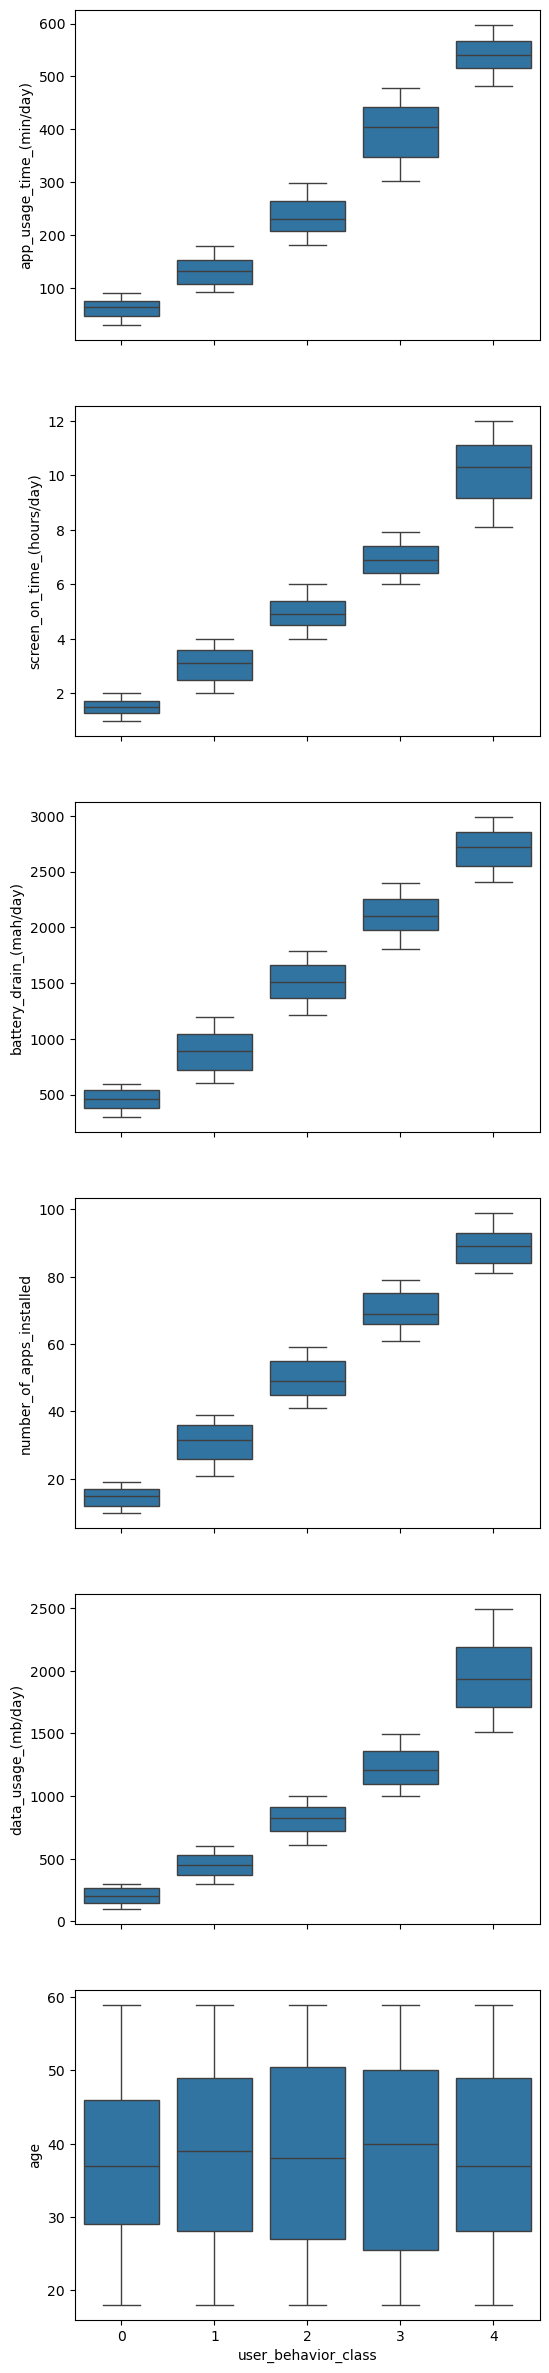

In [23]:
figure, axis = plt.subplots(nrows=len(numerical_features), sharex=True, figsize=(6, 30))
for i in range(len(numerical_features)):
    sns.boxplot(x=df.user_behavior_class, y=df[numerical_features[i]], ax=axis[i])

In [24]:
df_clean = df.drop(['age', 'operating_system', 'device_model'], axis=1)
df_clean.head()

,app_usage_time_(min/day),screen_on_time_(hours/day),battery_drain_(mah/day),number_of_apps_installed,data_usage_(mb/day),gender,user_behavior_class
0,393,6.4,1872,67,1122,1,3
1,268,4.7,1331,42,944,0,2
2,154,4.0,761,32,322,1,1
3,239,4.8,1676,56,871,1,2
4,187,4.3,1367,58,988,0,2


## Modeling

In [26]:
df_full_train, df_test = train_test_split(df_clean, test_size=0.2, random_state=12)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=12)

In [27]:
y_train = df_train.user_behavior_class.values
y_val = df_val.user_behavior_class.values
y_test = df_test.user_behavior_class.values
y_full_train = df_full_train.user_behavior_class.values

del(df_train['user_behavior_class'])
del(df_val['user_behavior_class'])
del(df_test['user_behavior_class'])
del(df_full_train['user_behavior_class'])

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

In [28]:
unique, count = np.unique(y_train, return_counts=True)
count, unique

(array([78, 88, 82, 82, 90], dtype=int64), array([0, 1, 2, 3, 4], dtype=int64))

In [29]:
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

### Modeling with XGBoost

In [31]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(features))
dval = xgb.DMatrix(X_val, feature_names=list(features))
dtest = xgb.DMatrix(X_test, feature_names=list(features))

In [32]:
%%time
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'multi:softmax',
    'num_class': 5,
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

CPU times: total: 15.6 ms
Wall time: 18.7 ms


In [33]:
%%time
y_pred = model.predict(dval)

CPU times: total: 0 ns
Wall time: 0 ns


In [34]:
(y_val == y_pred).mean()

1.0

In [35]:
y_pred = model.predict(dtest)
(y_test == y_pred).mean()

1.0

<Axes: >

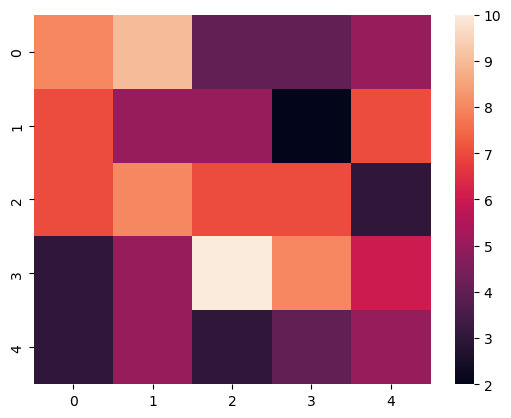

In [36]:
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(pd.DataFrame(cm))

We got the accuracy, precision, and recall `1.0`, means there is no `false positive` and `false negative`.

### Modeling with naive bayes

In [39]:
clf = GaussianNB(var_smoothing=0.01)

In [40]:
%%time
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

CPU times: total: 0 ns
Wall time: 7.63 ms


1.0

In [41]:
%%time
nb_pred = clf.predict(X_val)

CPU times: total: 15.6 ms
Wall time: 0 ns


<Axes: >

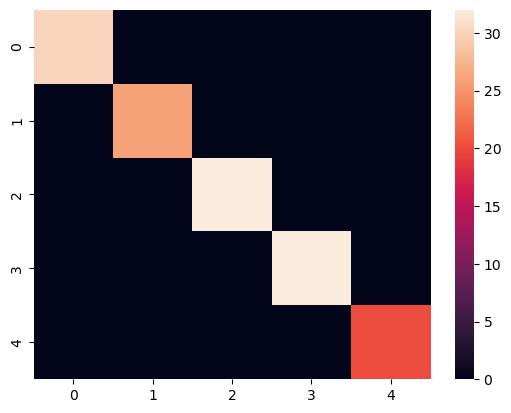

In [42]:
cm_nb = confusion_matrix(y_val, nb_pred)
sns.heatmap(pd.DataFrame(cm_nb))

In [43]:
y_pred = clf.predict_proba(X_val)
roc_auc_score(y_val, y_pred, multi_class='ovr')

1.0

### Modeling with KNN

In [45]:
%%time
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 11.9 ms


KNeighborsClassifier(n_neighbors=3)

In [46]:
%%time
y_pred = knn.predict(X_val)

CPU times: total: 0 ns
Wall time: 30.9 ms


In [47]:
knn.score(X_val, y_val)

1.0

In [48]:
df_clean

,app_usage_time_(min/day),screen_on_time_(hours/day),battery_drain_(mah/day),number_of_apps_installed,data_usage_(mb/day),gender,user_behavior_class
0,393,6.4,1872,67,1122,1,3
1,268,4.7,1331,42,944,0,2
2,154,4.0,761,32,322,1,1
3,239,4.8,1676,56,871,1,2
4,187,4.3,1367,58,988,0,2
...,...,...,...,...,...,...,...
695,92,3.9,1082,26,381,1,1
696,316,6.8,1965,68,1201,1,3
697,99,3.1,942,22,457,0,1
698,62,1.7,431,13,224,1,0


We got 100% accuration for all of the model. After look back to the model we got that the seperation between all of the categories is very clear. So we end up not tuning the model because no need tuning in this case

## Turn into pickle 

We use naive bayes model for the fastest computation

In [52]:
output_file = 'model.bin'
output_file

'model.bin'

In [53]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, clf), f_out)

In [59]:
df.iloc[101]

device_model                  OnePlus 9
operating_system                Android
app_usage_time_(min/day)            183
screen_on_time_(hours/day)          4.1
battery_drain_(mah/day)            1210
number_of_apps_installed             45
data_usage_(mb/day)                 738
age                                  19
gender                                1
user_behavior_class                   2
Name: 101, dtype: object

In [65]:
df.Gender.str.lower()

0        male
1      female
2        male
3        male
4      female
        ...  
695      male
696      male
697    female
698      male
699    female
Name: Gender, Length: 700, dtype: object

In [85]:
(clf.predict_proba(X_test)[0][1]).round(5)

0.0

In [101]:
import sklearn

sklearn.__version__, np.__version__, pd.__version__

('1.4.2', '1.26.4', '2.2.2')